In [79]:
%matplotlib inline
import math
import QuantLib as ql
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_style("whitegrid")

In [80]:
def to_dates(dates):
    return [d.to_date() for d in dates]

In [81]:
today = ql.Date(11, ql.December, 2012)
ql.Settings.instance().evaluationDate = today

In [82]:
helpers = [
    ql.DepositRateHelper(ql.QuoteHandle(ql.SimpleQuote(rate/100)),
                         ql.Period(1, ql.Days), fixingDays,
                         ql.TARGET(), ql.Following,
                         False, ql.Actual360())
    for rate, fixingDays in [(0.04, 0), (0.04, 1), (0.04, 2)]
]

In [83]:
eonia = ql.Eonia()
helpers += [
    ql.OISRateHelper(2, ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, tenor in [(0.070, (1, ql.Weeks)), (0.069, (2, ql.Weeks)),
                        (0.078, (3, ql.Weeks)), (0.074, (1, ql.Months))]
]

In [84]:
helpers += [
    ql.DatedOISRateHelper(start_date, end_date, ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, start_date, end_date in [
        ( 0.046, ql.Date(16,ql.January,2013), ql.Date(13,ql.February,2013)),
        ( 0.016, ql.Date(13,ql.February,2013), ql.Date(13,ql.March,2013)),
        (-0.007, ql.Date(13,ql.March,2013), ql.Date(10,ql.April,2013)),
        (-0.013, ql.Date(10,ql.April,2013), ql.Date(8,ql.May,2013)),
        (-0.014, ql.Date(8,ql.May,2013), ql.Date(12,ql.June,2013))
    ]
]

In [85]:
helpers += [
    ql.OISRateHelper(2, ql.Period(*tenor),
                     ql.QuoteHandle(ql.SimpleQuote(rate/100)), eonia)
    for rate, tenor in [(0.002, (15,ql.Months)), (0.008, (18,ql.Months)),
                        (0.021, (21,ql.Months)), (0.036, (2,ql.Years)),
                        (0.127, (3,ql.Years)), (0.274, (4,ql.Years)),
                        (0.456, (5,ql.Years)), (0.647, (6,ql.Years)),
                        (0.827, (7,ql.Years)), (0.996, (8,ql.Years)),
                        (1.147, (9,ql.Years)), (1.280, (10,ql.Years)),
                        (1.404, (11,ql.Years)), (1.516, (12,ql.Years)),
                        (1.764, (15,ql.Years)), (1.939, (20,ql.Years)),
                        (2.003, (25,ql.Years)), (2.038, (30,ql.Years))]
]

In [86]:
eonia_curve_c = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(),
                                             helpers, ql.Actual365Fixed())
eonia_curve_c.enableExtrapolation()

In [87]:
today = eonia_curve_c.referenceDate()
end = today + ql.Period(2, ql.Years)
dates = [ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber() + 1)]

In [88]:
today

Date(11,12,2012)

In [89]:
rates_c = [eonia_curve_c.forwardRate(d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(),
                                     ql.Simple).rate()
           for d in dates]

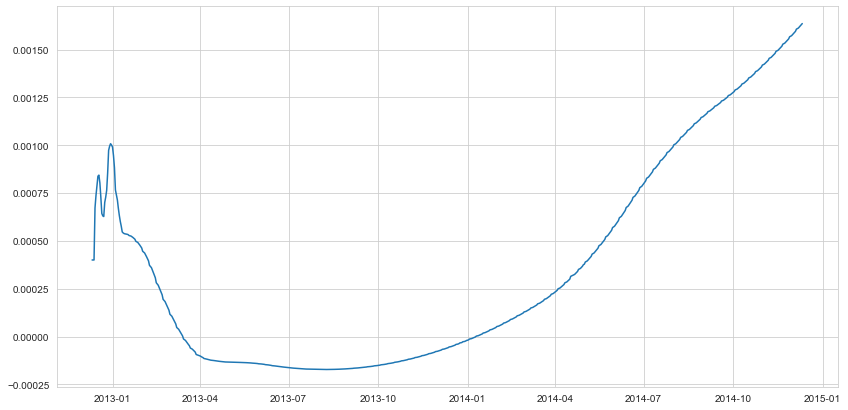

In [90]:
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates_c)

In [91]:
eonia_curve_ff = ql.PiecewiseFlatForward(0, ql.TARGET(), helpers, ql.Actual365Fixed())
eonia_curve_ff.enableExtrapolation()

In [92]:
end = today + ql.Period(6,ql.Months)
dates = [ ql.Date(serial) for serial in range(today.serialNumber(), end.serialNumber()+1)]
rates_ff = [eonia_curve_ff.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
            for d in dates ]

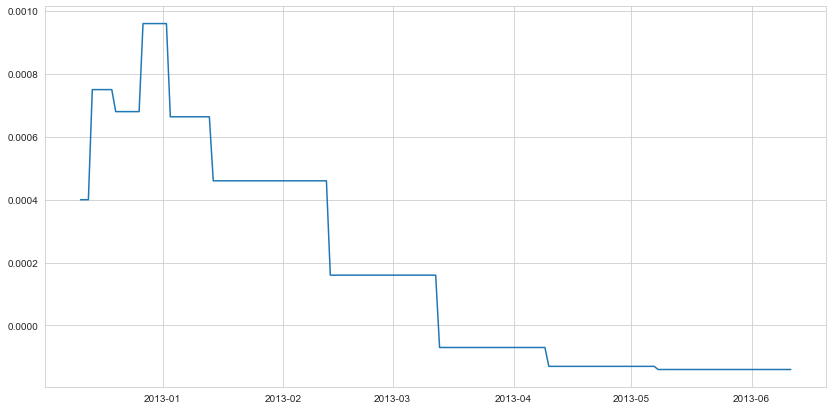

In [93]:
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates_ff)

In [94]:
nodes = list(eonia_curve_ff.nodes())
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.0009732981324671213),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

In [95]:
nodes[6] = (nodes[6][0], (nodes[5][1] + nodes[7][1]) / 2.0)
nodes[:9]

[(Date(11,12,2012), 0.00040555533025081675),
 (Date(12,12,2012), 0.00040555533025081675),
 (Date(13,12,2012), 0.00040555533047721286),
 (Date(14,12,2012), 0.00040555533047721286),
 (Date(20,12,2012), 0.0007604110692568178),
 (Date(27,12,2012), 0.0006894305026004767),
 (Date(3,1,2013), 0.000681123301587661),
 (Date(14,1,2013), 0.0006728161005748453),
 (Date(13,2,2013), 0.000466380545910482)]

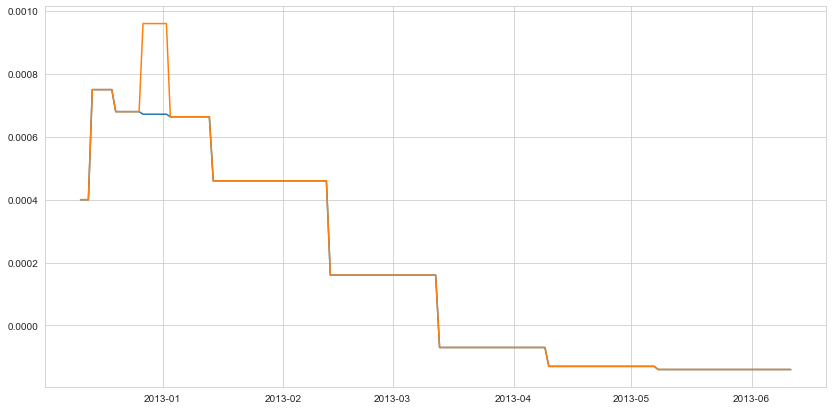

In [96]:
temp_dates, temp_rates = zip(*nodes)
temp_curve = ql.ForwardCurve(temp_dates, temp_rates, eonia_curve_ff.dayCounter())

temp_rates = [ temp_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days),
ql.Actual360(), ql.Simple).rate()
for d in dates ]

plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), temp_rates)
plt.plot(to_dates(dates), rates_ff)

In [97]:
d1 = ql.Date(31, ql.December, 2012) - ql.Period(1, ql.Weeks)
d2 = ql.Date(31, ql.December, 2012) + ql.Period(1, ql.Weeks)

F = eonia_curve_ff.forwardRate(d1, d2, ql.Actual360(), ql.Simple).rate()
F_1 = temp_curve.forwardRate(d1, d2, ql.Actual360(), ql.Simple).rate()
print(F * 100)
print(F_1 * 100)

0.08153067451794575
0.06712163624568644


In [98]:
t12 = eonia_curve_ff.dayCounter().yearFraction(d1, d2)
t_j = eonia_curve_ff.dayCounter().yearFraction(ql.Date(31, ql.December, 2012),
                                               ql.Date(2, ql.January, 2013))
J = (F - F_1) * t12 / t_j
print(J * 100)

0.1008632679058152


In [99]:
B = 1. / (1. + J * t_j)
jumps = [ql.QuoteHandle(ql.SimpleQuote(B))]
jumps_dates = [ql.Date(31, ql.December, 2012)]
eonia_curve_j = ql.PiecewiseFlatForward(0, ql.TARGET(),
                                        helpers, ql.Actual365Fixed(),
                                        jumps, jumps_dates)

In [100]:
rates_j = [eonia_curve_j.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
           for d in dates ]

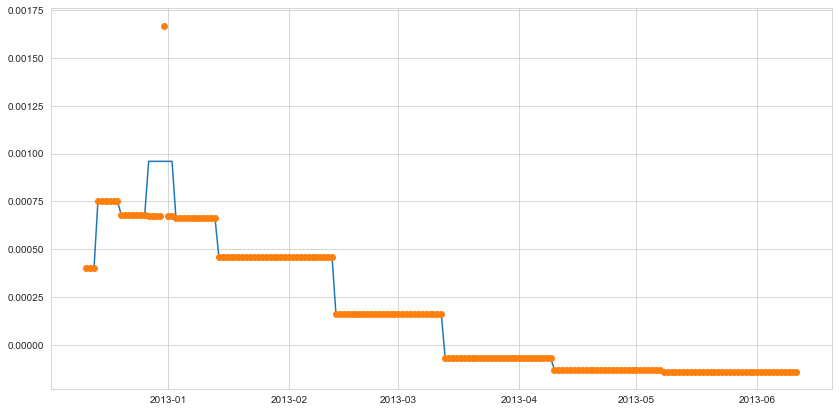

In [101]:
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates_ff)
plt.plot(to_dates(dates), rates_j, "o")

In [102]:
eonia_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(),
                                           helpers, ql.Actual365Fixed(),
                                           jumps, jumps_dates)
eonia_curve.enableExtrapolation()
rates_c = [eonia_curve_c.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
          for d in dates]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
          for d in dates]

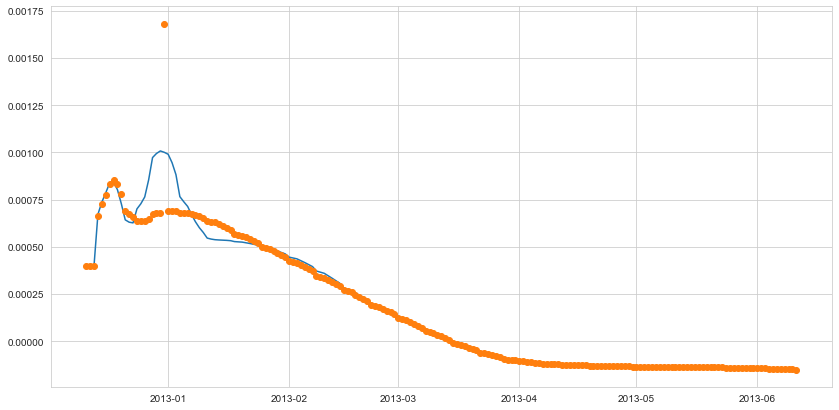

In [103]:
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates_c)
plt.plot(to_dates(dates), rates, "o")

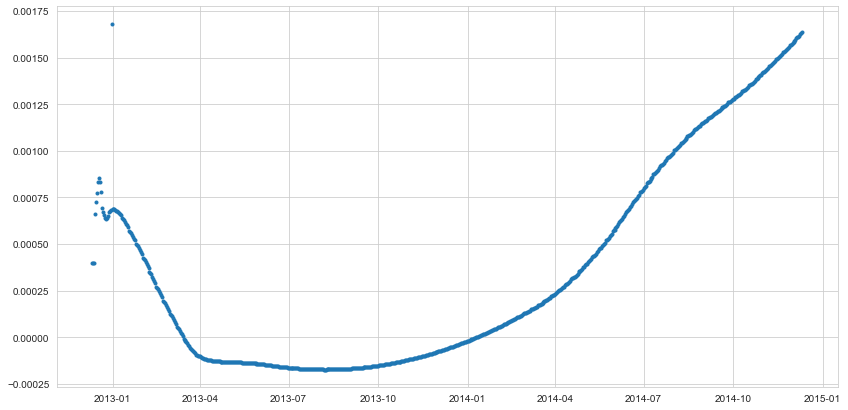

In [104]:
dates = [today + ql.Period(i, ql.Days) for i in range(0, 365*2 + 1)]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
         for d in dates ]
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates, '.')

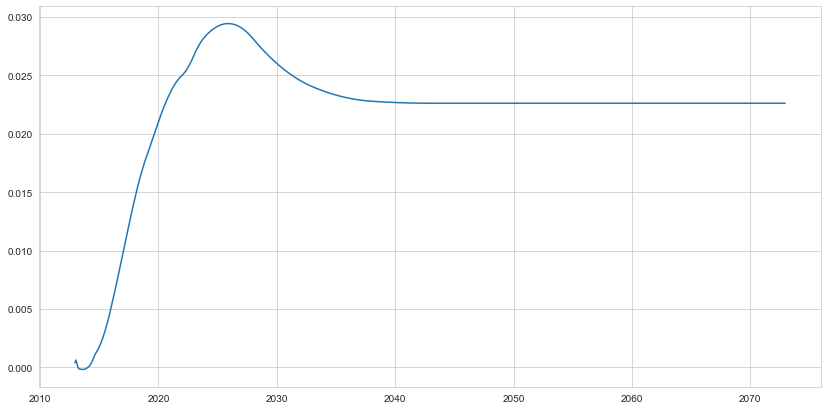

In [105]:
dates = [today+ql.Period(i,ql.Months) for i in range(0, 12*60+1)]
rates = [eonia_curve.forwardRate(d, ql.TARGET().advance(d,1,ql.Days), ql.Actual360(), ql.Simple).rate()
         for d in dates ]
plt.figure(figsize=(14, 7))
plt.plot(to_dates(dates), rates, '-')